## 1. Loading Necessary Libraries

In [1]:
import os
from sqlalchemy import create_engine
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from scipy import stats
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## 2. Connection to MySQL server

In [79]:
# Set environment variables
os.environ['MYSQL_DB_USERNAME'] = input("Enter the username of the environment variable:")
os.environ['MYSQL_DB_PASSWORD'] = input("Enter the password of the environment variable:")

# Get environment variables
user_name = os.environ.get('MYSQL_DB_USERNAME')
password = os.environ.get('MYSQL_DB_PASSWORD')

In [3]:
# DEFINE THE DATABASE CREDENTIALS
user = user_name
password = password
host = 'localhost'
port = 3306
database = 'Data_Glacier_Cab_Investment_firm'
  
# PYTHON FUNCTION TO CONNECT TO THE MYSQL DATABASE 
engine= create_engine(url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, database))
connection=engine.connect()

## 3. Read the dataset:

In [4]:
Tables = pd.read_sql("""SELECT table_name, table_schema, create_time
                        FROM information_schema.tables 
                        WHERE table_schema='Data_Glacier_Cab_Investment_firm';""", con=connection)
Tables

,TABLE_NAME,TABLE_SCHEMA,CREATE_TIME
0,Cab_Data,Data_Glacier_Cab_Investment_firm,2022-08-09 02:45:20
1,Customer_ID,Data_Glacier_Cab_Investment_firm,2022-08-09 03:14:39
2,Transaction_ID,Data_Glacier_Cab_Investment_firm,2022-08-09 03:00:26
3,city,Data_Glacier_Cab_Investment_firm,2022-08-09 03:16:48


In [5]:
Cab_df = pd.read_sql("""SELECT * FROM Cab_Data;""", con=connection)
Cab_df.sample(10)

,Transaction_ID,Date_of_Travel,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip
198077,10243218,43027,Yellow Cab,NEW YORK NY,14.43,285.27,195.6708
320589,10393397,43391,Yellow Cab,CHICAGO IL,11.64,187.83,156.4416
78254,10096945,42674,Yellow Cab,NEW YORK NY,8.88,235.65,119.3472
161735,10199462,42948,Pink Cab,LOS ANGELES CA,29.40,331.95,335.1600
225335,10275513,43079,Pink Cab,NEW YORK NY,30.00,673.28,342.0000
328025,10402077,43402,Yellow Cab,NEW YORK NY,15.84,401.82,203.3856
26393,10033571,42506,Yellow Cab,SEATTLE WA,20.60,332.00,274.3920
222868,10272637,43077,Yellow Cab,NEW YORK NY,24.64,675.15,316.3776
181562,10223473,42996,Yellow Cab,CHICAGO IL,31.36,598.43,398.8992
313096,10384392,43372,Yellow Cab,WASHINGTON DC,8.19,148.05,111.0564


In [6]:
Customer_df = pd.read_sql("""SELECT * FROM Customer_ID;""", con=connection)
Customer_df.sample(10)

,Customer_ID,Gender,Age,Income_USDMonth
13837,14283,Male,26,11677
14872,15477,Female,26,24017
10099,10229,Male,49,24895
47746,58576,Female,47,24473
8557,8558,Male,24,2050
41919,51622,Male,37,33240
2287,2288,Male,33,8637
4244,4245,Female,19,16421
11272,11537,Female,65,5663
21554,24328,Female,35,24621


In [7]:
Transaction_df = pd.read_sql("""SELECT * FROM Transaction_ID;""", con=connection)
Transaction_df.sample(10)

,Transaction_ID,Customer_ID,Payment_Mode
222811,10222822,39669,Card
358399,10358410,52199,Cash
164042,10164053,2962,Cash
206442,10206453,59683,Card
148656,10148667,50,Card
344298,10344309,8033,Card
387228,10387239,720,Card
95827,10095838,44416,Card
14081,10014092,44627,Card
322013,10322024,52267,Card


In [8]:
city_df = pd.read_sql("""SELECT * FROM city;""", con=connection)
city_df

,City,Population,Users
0,ATLANTA GA,"814,885","24,701"
1,AUSTIN TX,"698,371","14,978"
2,BOSTON MA,"248,968","80,021"
3,CHICAGO IL,"1,955,130","164,468"
4,DALLAS TX,"942,908","22,157"
5,DENVER CO,"754,233","12,421"
6,LOS ANGELES CA,"1,595,037","144,132"
7,MIAMI FL,"1,339,155","17,675"
8,NASHVILLE TN,"327,225","9,270"
9,NEW YORK NY,"8,405,837","302,149"


### Data Cleaning: 

#### master dataset: result from the merge of the 4 datasets provided to this project|

In [9]:
Master_Data = pd.read_sql("""   SELECT                                          
                                    T1.Customer_ID, T2.Transaction_ID, T1.Gender,
                                    T1.Age, T1.Income_USDMonth, T2.Payment_Mode,
                                    T3.Company, T3.City, T3.KM_Travelled, T3.Price_Charged,
                                    T3.Cost_of_Trip, T3.Date_of_Travel,
                                    T4.Population, T4.Users

                                FROM
                                    Customer_ID T1, Transaction_ID T2, Cab_Data T3, city T4

                                WHERE
                                    T1.Customer_ID = T2.Customer_ID 

                                AND
                                    T2.Transaction_ID = T3.Transaction_ID

                                AND
                                    T3.City = T4.City;"""
                                    , con=connection)

Master_Data.sample(5)
#Python
# master_data = Cab_df.merge(Transaction_df, on= 'Transaction_ID').merge(Customer_df, on ='Customer_ID').merge(city_df, on = 'City')

,Customer_ID,Transaction_ID,Gender,Age,Income_USDMonth,Payment_Mode,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Date_of_Travel,Population,Users
348874,996,10426957,Male,26,8639,Card,Yellow Cab,NEW YORK NY,24.96,588.16,350.4384,43446,"8,405,837","302,149"
46926,7388,10059259,Male,37,10894,Card,Pink Cab,LOS ANGELES CA,8.08,103.07,86.4560,42588,"1,595,037","144,132"
350218,3565,10428636,Female,36,24175,Cash,Pink Cab,CHICAGO IL,25.20,322.36,284.7600,43455,"1,955,130","164,468"
339893,6341,10416263,Female,57,21127,Cash,Pink Cab,LOS ANGELES CA,36.36,465.77,436.3200,43434,"1,595,037","144,132"
91724,8714,10112947,Female,35,16875,Cash,Pink Cab,LOS ANGELES CA,36.38,586.70,374.7140,42701,"1,595,037","144,132"


#### Missing values check:

In [10]:
Master_Data.isnull().sum() 

Customer_ID        0
Transaction_ID     0
Gender             0
Age                0
Income_USDMonth    0
Payment_Mode       0
Company            0
City               0
KM_Travelled       0
Price_Charged      0
Cost_of_Trip       0
Date_of_Travel     0
Population         0
Users              0
dtype: int64

#### Dedupe check:

In [11]:
duplicated_rows = Master_Data[Master_Data.duplicated()]
print('Total number of duplicated rows is', duplicated_rows.shape[0])

Total number of duplicated rows is 0


#### Prepare Data

In [12]:
# change the date form, add columns for Year, Month, Day
start =pd.Timestamp('1899-12-30')
Master_Data["Date_of_Travel"] = pd.to_datetime(Master_Data["Date_of_Travel"], unit="D", origin = start)
Master_Data['Year'] = Master_Data['Date_of_Travel'].dt.year
Master_Data['Month'] = Master_Data['Date_of_Travel'].dt.month

In [13]:
# new column for Age_range
bins = [18, 19, 29, 39, 49, 59, 69]
labels = ['18-19', '20-29', '30-39', '40-49', '50-59', '60+']
Master_Data['Age_Range'] = pd.cut(Master_Data.Age, bins, labels = labels,include_lowest = True)

In [14]:
## Let's calculate the margin between 'Price_Charged' and 'Cost_of_Trip' and call it 'Margin'.
Master_Data["Margin"]= Master_Data['Price_Charged']-Master_Data['Cost_of_Trip']
Master_Data['Margin_Percentage'] =(Master_Data["Margin"]*100) /Master_Data['Price_Charged']

In [15]:
#  Attribute 'Population' should be an integer
Master_Data['Population'] = [x.replace(',','') for x in Master_Data['Population']]
Master_Data['Population'] = Master_Data['Population'].astype(float)

# Attribute 'Users' should be an integer
Master_Data['Users'] = [x.replace(',','') for x in Master_Data['Users']]
Master_Data['Users'] = Master_Data['Users'].astype(float)
Master_Data.sample(5)

,Customer_ID,Transaction_ID,Gender,Age,Income_USDMonth,Payment_Mode,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Date_of_Travel,Population,Users,Year,Month,Age_Range,Margin,Margin_Percentage
177436,56313,10218555,Female,22,19694,Card,Pink Cab,NASHVILLE TN,20.06,200.98,238.714,2017-09-08,327225.0,9270.0,2017,9,20-29,-37.734,-18.775002
267665,53950,10328569,Female,22,10481,Cash,Yellow Cab,WASHINGTON DC,21.42,387.99,295.596,2018-05-10,418859.0,127001.0,2018,5,20-29,92.394,23.813500
295377,5856,10362982,Male,31,20295,Cash,Yellow Cab,CHICAGO IL,2.14,30.17,25.680,2018-08-15,1955130.0,164468.0,2018,8,30-39,4.490,14.882333
266052,59062,10326495,Male,23,18679,Card,Pink Cab,BOSTON MA,4.76,51.10,47.600,2018-05-08,248968.0,80021.0,2018,5,20-29,3.500,6.849315
172901,4493,10213129,Male,40,23134,Card,Yellow Cab,CHICAGO IL,19.04,348.25,228.480,2017-08-21,1955130.0,164468.0,2017,8,40-49,119.770,34.391960


In [16]:
Master_Data.describe(include='all')

/tmp/ipykernel_10196/2422596532.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  Master_Data.describe(include='all')


,Customer_ID,Transaction_ID,Gender,Age,Income_USDMonth,Payment_Mode,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Date_of_Travel,Population,Users,Year,Month,Age_Range,Margin,Margin_Percentage
count,359392.000000,3.593920e+05,359392,359392.000000,359392.000000,359392,359392,359392,359392.000000,359392.000000,359392.000000,359392,3.593920e+05,359392.000000,359392.000000,359392.000000,359392,359392.000000,359392.000000
unique,NaN,NaN,2,NaN,NaN,2,2,19,NaN,NaN,NaN,1095,NaN,NaN,NaN,NaN,6,NaN,NaN
top,NaN,NaN,Male,NaN,NaN,Card,Yellow Cab,NEW YORK NY,NaN,NaN,NaN,2018-01-05 00:00:00,NaN,NaN,NaN,NaN,20-29,NaN,NaN
freq,NaN,NaN,205912,NaN,NaN,215504,274681,99885,NaN,NaN,NaN,2022,NaN,NaN,NaN,NaN,116430,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,19191.652115,1.022076e+07,NaN,35.336705,15048.822937,NaN,NaN,NaN,22.567254,423.443311,286.190113,NaN,3.132198e+06,158365.582267,2017.045199,7.500434,NaN,137.253198,27.128413
std,21012.412463,1.268058e+05,NaN,12.594234,7969.409482,NaN,NaN,NaN,12.233526,274.378911,157.993661,NaN,3.315194e+06,100850.051020,0.800239,3.445095,NaN,160.311840,18.550100
min,1.000000,1.000001e+07,NaN,18.000000,2000.000000,NaN,NaN,NaN,1.900000,15.600000,19.000000,NaN,2.489680e+05,3643.000000,2016.000000,1.000000,NaN,-220.060000,-69.301505
25%,2705.000000,1.011081e+07,NaN,25.000000,8424.000000,NaN,NaN,NaN,12.000000,206.437500,151.200000,NaN,6.712380e+05,80021.000000,2016.000000,5.000000,NaN,28.012000,13.855876


In [17]:
print("shape:", Master_Data.shape)
print('\n', Master_Data.info())

shape: (359392, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Customer_ID        359392 non-null  int64         
 1   Transaction_ID     359392 non-null  int64         
 2   Gender             359392 non-null  object        
 3   Age                359392 non-null  int64         
 4   Income_USDMonth    359392 non-null  int64         
 5   Payment_Mode       359392 non-null  object        
 6   Company            359392 non-null  object        
 7   City               359392 non-null  object        
 8   KM_Travelled       359392 non-null  float64       
 9   Price_Charged      359392 non-null  float64       
 10  Cost_of_Trip       359392 non-null  float64       
 11  Date_of_Travel     359392 non-null  datetime64[ns]
 12  Population         359392 non-null  float64       
 13  Users              35939

## Analysis

In [18]:
def sub_axbarplot(X,Y1,Y2,Xlab,Ylab,titles,nb_rows,nb_columns,fig):
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.6)
    itm=0
    cursor=1
    for i in titles:
        indexs = np.arange(len(X[itm]))
        ax = plt.subplot(nb_rows, nb_columns, cursor)
        if isinstance(X[itm], int)==True: # test if the indexs are int
            ax.bar(X[itm]-0.1, Y1[itm], width=0.2, color='pink', align='center',label='Pink Cab')
            ax.bar(X[itm]+0.1, Y2[itm], width=0.2, color='yellow', align='center',label='Yellow Cab') 
        else:
            ax.bar(indexs -0.1, Y1[itm], width=0.2, color='pink', align='center',label='Pink Cab')
            ax.bar(indexs +0.1, Y2[itm], width=0.2, color='yellow', align='center',label='Yellow Cab')
        plt.title('{}'.format(i), fontsize = 12)
        plt.xlabel(Xlab[itm], fontsize = 12)
        plt.ylabel(Ylab[itm], fontsize = 12)
        plt.xticks()
        ax.set_xticks(indexs)
        ax.set_xticklabels(X[itm].astype(str).values, rotation=60)

        plt.legend()
        cursor += 1
        itm += 1
    plt.show()

def sub_histplot(Master_Data,X,Xlab,Ylab,titles,nb_rows,nb_columns,color,fig):
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)
    itm=0
    cursor=1
    for i in titles:
        plt.subplot(nb_rows, nb_columns, cursor)
        plt.title('{}'.format(i), fontsize = 12)
        plt.xlabel(Xlab[itm], fontsize = 12)
        plt.ylabel(Ylab[itm], fontsize = 12)
        plt.xticks(rotation=60)
        sns.histplot(data=Master_Data, x=X[itm],bins=40, color= color)
        cursor += 1
        itm += 1
    plt.show()  
    
def sub_pieplot(X,titles,nb_rows,nb_columns,fig):
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.2)
    itm=0
    cursor=1
    for i in titles:
        plt.subplot(nb_rows, nb_columns, cursor)
        plt.title('{}'.format(i), fontsize = 12)
        labels= X[itm].index
        plt.pie(x=X[itm], autopct="%.1f%%", labels=labels, pctdistance=0.5, startangle=60,shadow=True)
        plt.xticks(rotation=90)
        cursor += 1
        itm += 1
    plt.show()  

# def sub_barplot(X,Y,Xlab,Ylab,titles,nb_rows,nb_columns,fig):
#     plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.6)
#     itm=0
#     cursor=1
#     for i in titles:
#         plt.subplot(nb_rows, nb_columns, cursor)
#         plt.title('{}'.format(i), fontsize = 12)
#         plt.xlabel(Xlab[itm], fontsize = 12)
#         plt.ylabel(Ylab[itm], fontsize = 12)
#         plt.xticks(rotation=60)
#         sns.barplot(X[itm],Y[itm])
#         cursor += 1
#         itm += 1
#     plt.show()

In [19]:
MTA_Pink = Master_Data[Master_Data.Company=='Pink Cab'].groupby(['Month']).Transaction_ID.count()
YTA_Pink = Master_Data[Master_Data.Company=='Pink Cab'].groupby(['Year']).Transaction_ID.count()

MTA_Yellow = Master_Data[Master_Data.Company=='Yellow Cab'].groupby(['Month']).Transaction_ID.count()
YTA_Yellow = Master_Data[Master_Data.Company=='Yellow Cab'].groupby(['Year']).Transaction_ID.count()

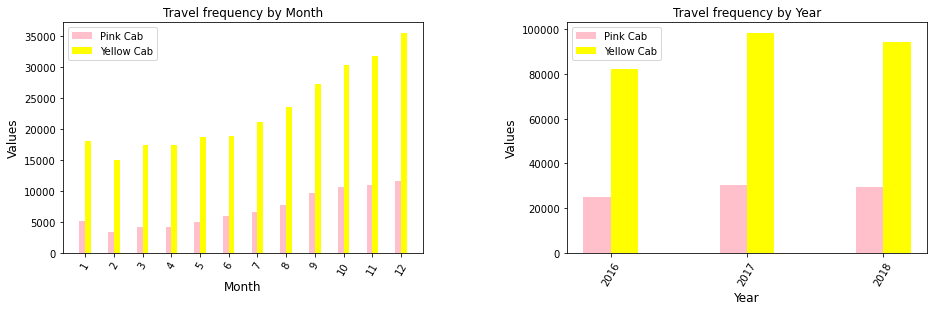

In [20]:
X=[MTA_Pink.index, YTA_Pink.index]  
Y1=[MTA_Pink.values, YTA_Pink.values] 
Y2=[MTA_Yellow.values, YTA_Yellow.values] 
Xlab=['Month','Year']                                                  
Ylab=['Values','Values']  
titles = ['Travel frequency by Month', 'Travel frequency by Year']            
fig = plt.figure(figsize=(15,4))

sub_axbarplot(X,Y1,Y2,Xlab,Ylab,titles,1,2,fig)

#### Analysis: It is observed that most of the travels occur in December for both companies. It is also observed that the year 2017 has more travels for both cabs.

In [21]:
MKM_Pink = Master_Data[Master_Data.Company=='Pink Cab'].groupby(['Month']).KM_Travelled.sum()
YKM_Pink = Master_Data[Master_Data.Company=='Pink Cab'].groupby(['Year']).KM_Travelled.sum()

MKM_Yellow = Master_Data[Master_Data.Company=='Yellow Cab'].groupby(['Month']).KM_Travelled.sum()
YKM_Yellow = Master_Data[Master_Data.Company=='Yellow Cab'].groupby(['Year']).KM_Travelled.sum()

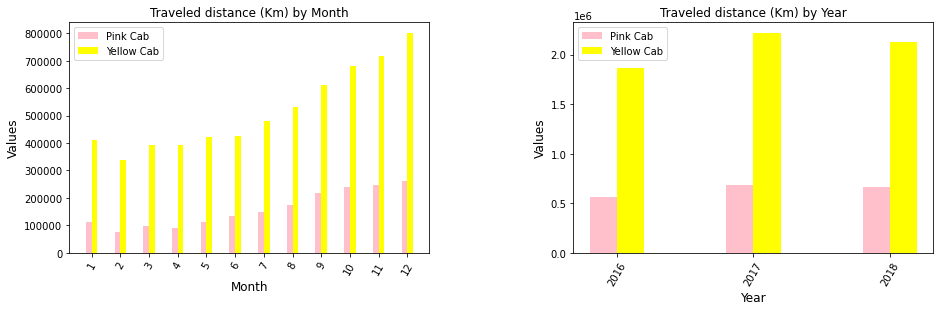

In [22]:
X=[MKM_Pink.index, YKM_Pink.index]  
Y1=[MKM_Pink.values, YKM_Pink.values]
Y2=[MKM_Yellow.values, YKM_Yellow.values] 
Xlab=['Month','Year']                                                  
Ylab=['Values','Values']  
titles = ['Traveled distance (Km) by Month', 'Traveled distance (Km) by Year']            
fig = plt.figure(figsize=(15,4))

sub_axbarplot(X,Y1,Y2,Xlab,Ylab,titles,1,2,fig)

Let's see the percentage of traveled distance for each Month/Year.

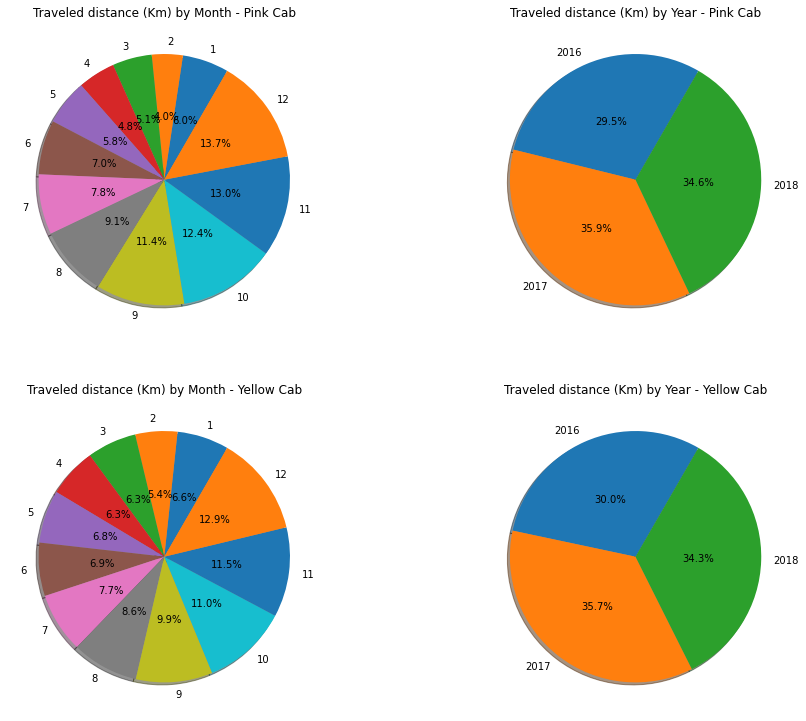

In [23]:
X=[MKM_Pink, YKM_Pink, MKM_Yellow, YKM_Yellow] 
titles = ['Traveled distance (Km) by Month - Pink Cab', 'Traveled distance (Km) by Year - Pink Cab', 'Traveled distance (Km) by Month - Yellow Cab', 'Traveled distance (Km) by Year - Yellow Cab']            
fig = plt.figure(figsize=(15,12))
sub_pieplot(X,titles,2,2,fig)

In [24]:
Payment_Mode_Pink = Master_Data[Master_Data.Company=='Pink Cab'].groupby(['Payment_Mode']).Customer_ID.count()
Payment_Mode_Yellow = Master_Data[Master_Data.Company=='Yellow Cab'].groupby(['Payment_Mode']).Customer_ID.count()

Gender_Pink = Master_Data[Master_Data.Company=='Pink Cab'].groupby(['Gender']).Customer_ID.count()
Gender_Yellow = Master_Data[Master_Data.Company=='Yellow Cab'].groupby(['Gender']).Customer_ID.count()

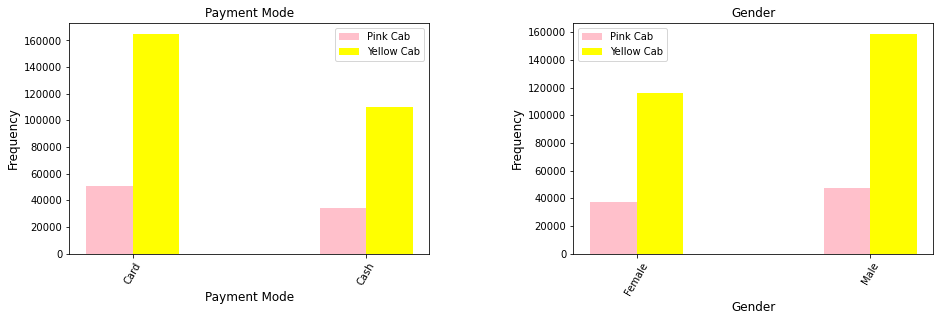

In [25]:
X=[Payment_Mode_Pink.index, Gender_Pink.index]  
Y1=[Payment_Mode_Pink.values, Gender_Pink.values]
Y2=[Payment_Mode_Yellow.values, Gender_Yellow.values] 
Xlab=["Payment Mode", "Gender"]                                                  
Ylab=['Frequency','Frequency']  
titles = ['Payment Mode', 'Gender']            
fig = plt.figure(figsize=(15,4))

sub_axbarplot(X,Y1,Y2,Xlab,Ylab,titles,1,2,fig)

#### Analysis: it is observed that customers of both companies prefer to pay by card. It is also observed that most customers are Males.

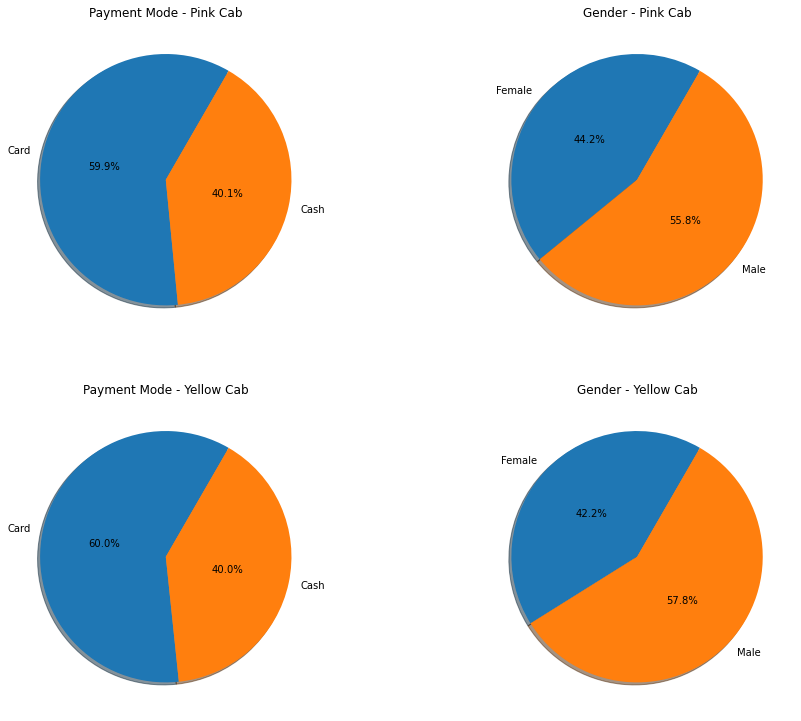

In [26]:
X=[Payment_Mode_Pink, Gender_Pink, Payment_Mode_Yellow, Gender_Yellow] 
titles = ['Payment Mode - Pink Cab', 'Gender - Pink Cab', 'Payment Mode - Yellow Cab', 'Gender - Yellow Cab']            
fig = plt.figure(figsize=(15,12))
sub_pieplot(X,titles,2,2,fig)

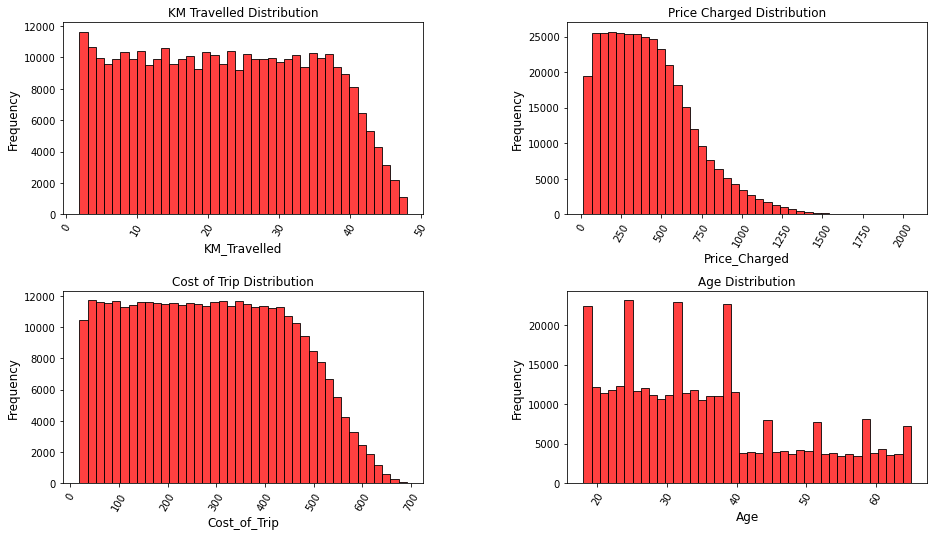

In [27]:
X=["KM_Travelled", "Price_Charged", "Cost_of_Trip", "Age"]  
Xlab=["KM_Travelled", "Price_Charged", "Cost_of_Trip", "Age"]                                                  
Ylab=['Frequency','Frequency','Frequency','Frequency']  
titles = ['KM Travelled Distribution', 'Price Charged Distribution',  'Cost of Trip Distribution', 'Age Distribution']            
fig = plt.figure(figsize=(15,8))

sub_histplot(Master_Data,X,Xlab,Ylab,titles,2,2,'r',fig)

#### Analysis: It is observed that the most of the rides varies from 2 to 48 KM. Most of the charged prices are between 15.6 and 600 Dollar, and then the number starts to decrease. Most of the costs are varied from 19.0 to 691.2 Dollar where the maximum cost is around 690. Regarding the age of the customers, up to 80k are customers within the age of 18, 24, 31 and 39 years; execept these ages, there are up to 10k customers for each age between 19 and 40, and les than 7k costomers for each age >40 years. 

In [28]:
Master_Data_Pink = Master_Data[Master_Data.Company=='Pink Cab']
Master_Data_Yellow = Master_Data[Master_Data.Company=='Yellow Cab']

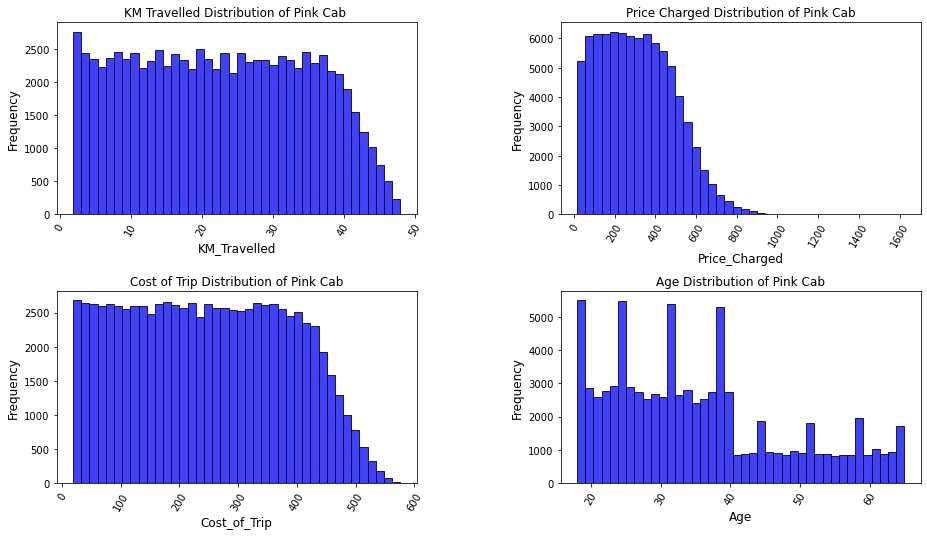

In [29]:
X=["KM_Travelled", "Price_Charged", "Cost_of_Trip", "Age"]  
Xlab=["KM_Travelled", "Price_Charged", "Cost_of_Trip", "Age"]                                                  
Ylab=['Frequency','Frequency','Frequency','Frequency']  
titles = ['KM Travelled Distribution of Pink Cab ', 'Price Charged Distribution of Pink Cab',  'Cost of Trip Distribution of Pink Cab', 'Age Distribution of Pink Cab']            
fig = plt.figure(figsize=(15,8))

sub_histplot(Master_Data_Pink,X,Xlab,Ylab,titles,2,2,'b',fig)

In [30]:
min_p = Master_Data_Pink['Cost_of_Trip'].unique().min()
max_p = Master_Data_Pink['Cost_of_Trip'].unique().max()
print(min_p,max_p)

19.0 576.0


#### Analysis: it is observed that most of the costs of the Pink Cab are varied between 19 and 500 Dollar, where the rest are varying between 500 and 576 Dollar.

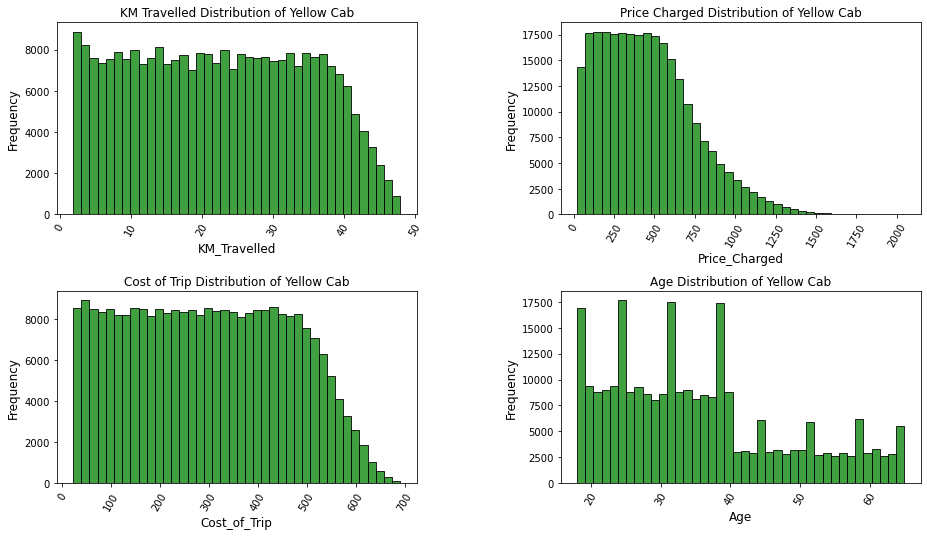

In [31]:
X=["KM_Travelled", "Price_Charged", "Cost_of_Trip", "Age"]  
Xlab=["KM_Travelled", "Price_Charged", "Cost_of_Trip", "Age"]                                                  
Ylab=['Frequency','Frequency','Frequency','Frequency']  
titles = ['KM Travelled Distribution of Yellow Cab', 'Price Charged Distribution of Yellow Cab',  'Cost of Trip Distribution of Yellow Cab', 'Age Distribution of Yellow Cab']            
fig = plt.figure(figsize=(15,8))

sub_histplot(Master_Data_Yellow,X,Xlab,Ylab,titles,2,2,'g',fig)

In [32]:
min_y = Master_Data_Yellow['Cost_of_Trip'].unique().min()
max_y = Master_Data_Yellow['Cost_of_Trip'].unique().max()
print(min_y, max_y)

22.8 691.2


#### Analysis: it is observed that most of the costs of the Yellow Cab are varied between 22 and 600 Dollar, where the rest are varying between 600 and 691 Dollar

## Price:

In [33]:
Price_Charged_Y_Pink = Master_Data_Pink.groupby(['Year']).Price_Charged.mean()
Price_Charged_Y_Yellow = Master_Data_Yellow.groupby(['Year']).Price_Charged.mean()

Price_Charged_M_Pink = Master_Data_Pink.groupby(['Month']).Price_Charged.mean()
Price_Charged_M_Yellow = Master_Data_Yellow.groupby(['Month']).Price_Charged.mean()

Price_Charged_City_Pink = Master_Data_Pink.groupby(['City']).Price_Charged.mean()
Price_Charged_City_Yellow = Master_Data_Yellow.groupby(['City']).Price_Charged.mean()

Price_Charged_AgeRange_Pink = Master_Data_Pink.groupby(['Age_Range']).Price_Charged.mean()
Price_Charged_AgeRange_Yellow = Master_Data_Yellow.groupby(['Age_Range']).Price_Charged.mean()


Price_Charged_Gender_Pink = Master_Data_Pink.groupby(['Gender']).Price_Charged.mean()
Price_Charged_Gender_Yellow = Master_Data_Yellow.groupby(['Gender']).Price_Charged.mean()

Price_Charged_PaymentMode_Pink = Master_Data_Pink.groupby(['Payment_Mode']).Price_Charged.mean()
Price_Charged_PaymentMode_Yellow = Master_Data_Yellow.groupby(['Payment_Mode']).Price_Charged.mean()

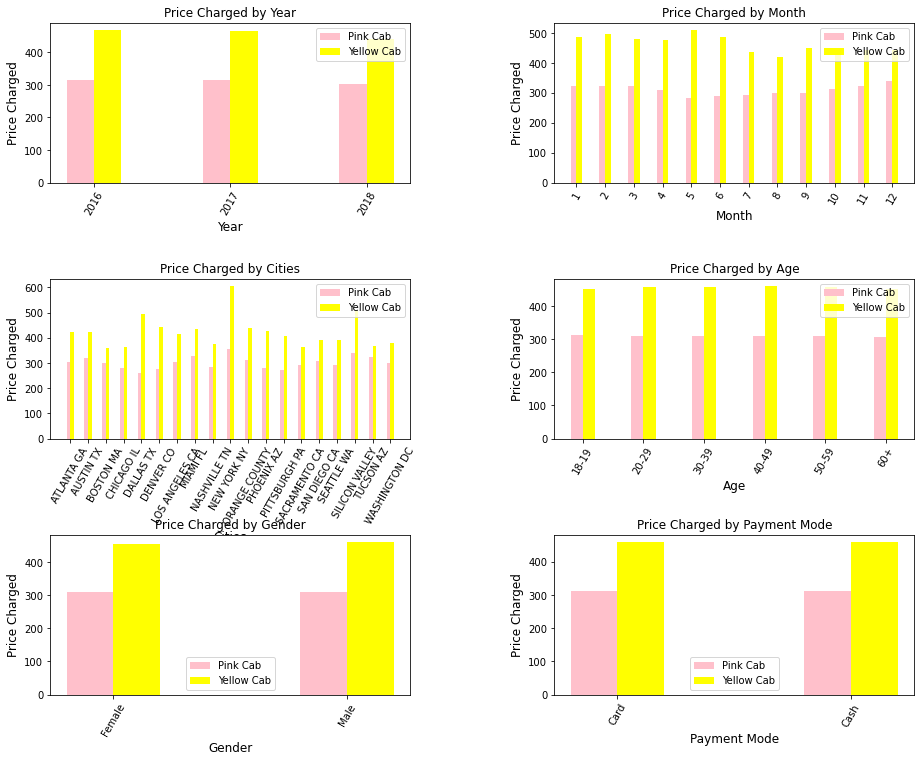

In [34]:
X=[Price_Charged_Y_Pink.index, Price_Charged_M_Pink.index, Price_Charged_City_Pink.index, Price_Charged_AgeRange_Pink.index, Price_Charged_Gender_Pink.index, Price_Charged_PaymentMode_Pink.index] 
Y1=[Price_Charged_Y_Pink.values, Price_Charged_M_Pink.values, Price_Charged_City_Pink.values, Price_Charged_AgeRange_Pink.values, Price_Charged_Gender_Pink.values, Price_Charged_PaymentMode_Pink.values] 
Y2=[Price_Charged_Y_Yellow.values, Price_Charged_M_Yellow.values, Price_Charged_City_Yellow.values, Price_Charged_AgeRange_Yellow.values, Price_Charged_Gender_Yellow.values, Price_Charged_PaymentMode_Yellow.values]
Xlab=["Year", "Month", "Cities","Age", "Gender", "Payment Mode"]                                                  
Ylab=['Price Charged','Price Charged','Price Charged', 'Price Charged','Price Charged','Price Charged']  
titles = ['Price Charged by Year', 'Price Charged by Month', 'Price Charged by Cities', 'Price Charged by Age', 'Price Charged by Gender', 'Price Charged by Payment Mode']            
fig = plt.figure(figsize=(15,25))
sub_axbarplot(X,Y1,Y2,Xlab,Ylab,titles,6,2,fig)

#### Analysis: it is observed that the price charged of Yellow Cab is higher for all the categories (seasons, cities, age, gender and payment mode). Besides, it is clear that the price is highly variated by month and city.

## Age and Cities Analysis:

In [35]:
Age_Range_Pink = Master_Data_Pink.groupby(['Age_Range']).Customer_ID.count()
Age_Range_Yellow = Master_Data_Yellow.groupby(['Age_Range']).Customer_ID.count()

City_Pink=Master_Data_Pink.groupby(['City']).Customer_ID.count()
City_Yellow = Master_Data_Yellow.groupby(['City']).Customer_ID.count()

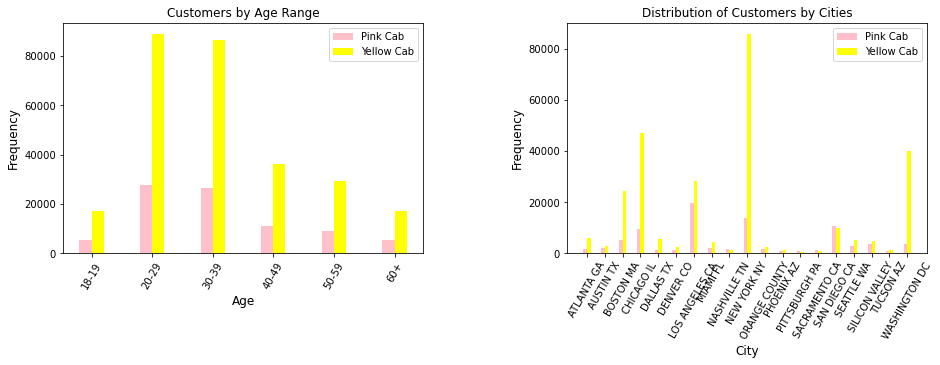

In [36]:
X=[Age_Range_Pink.index, City_Pink.index]
Y1=[Age_Range_Pink.values, City_Pink.values]
Y2=[Age_Range_Yellow.values, City_Yellow.values] 
Xlab=["Age", "City"]                                                  
Ylab=['Frequency','Frequency']  
titles = ['Customers by Age Range', 'Distribution of Customers by Cities']            
fig = plt.figure(figsize=(15,4))

sub_axbarplot(X,Y1,Y2,Xlab,Ylab,titles,1,2,fig)

#### Analysis: it is observed that most of the ages are between 20 and 40 years for both companies. It is also observed that most customers of the Pink Cab are from LOS ANGELES CA whereas most of the customers of the Yellow Cab are from NEW YORK.

To see the percentage of the distribution let's plot the pieplot chart.

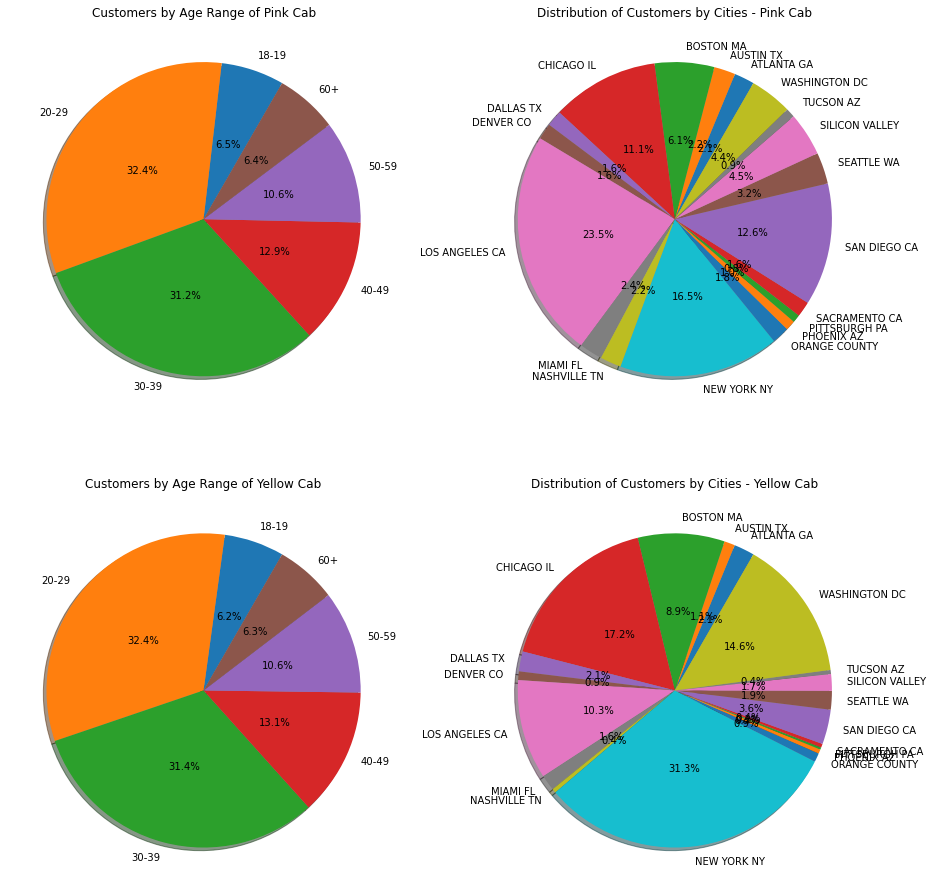

In [37]:
X=[Age_Range_Pink, City_Pink, Age_Range_Yellow, City_Yellow] 
titles = ['Customers by Age Range of Pink Cab', 'Distribution of Customers by Cities - Pink Cab',  'Customers by Age Range of Yellow Cab', 'Distribution of Customers by Cities - Yellow Cab']       
fig = plt.figure(figsize=(15,15))
sub_pieplot(X,titles,2,2,fig)

## Margin Analysis:

In [38]:
Margin_Total = Master_Data.groupby(['Company']).Margin.mean()
Margin_Y = Master_Data.groupby(['Company', 'Year']).Margin.mean()

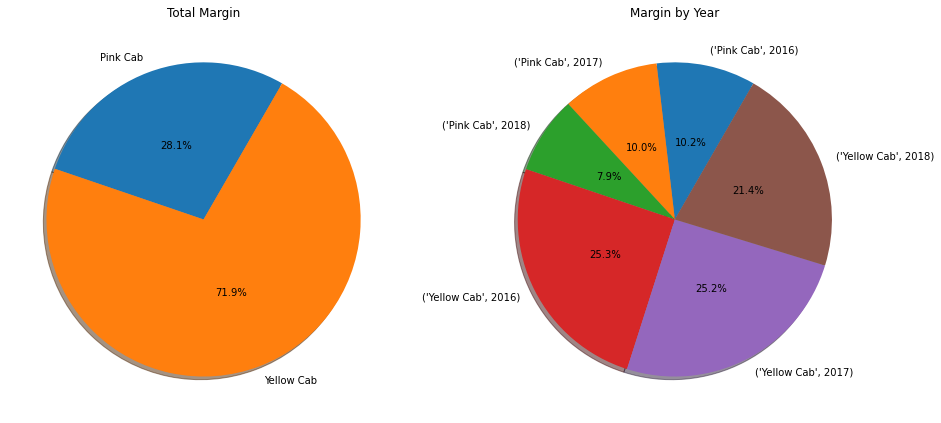

In [39]:
X=[Margin_Total, Margin_Y] 
titles = ['Total Margin', 'Margin by Year']       
fig = plt.figure(figsize=(15,15))
sub_pieplot(X,titles,1,2,fig)

### Analysis: Yellow cab owns 71.9% of the total margin made by both companies.

In [40]:
Margin_Y_Pink = Master_Data_Pink.groupby(['Year']).Margin_Percentage.mean()
Margin_Y_Yellow = Master_Data_Yellow.groupby(['Year']).Margin_Percentage.mean()

Margin_M_Pink = Master_Data_Pink.groupby(['Month']).Margin_Percentage.mean()
Margin_M_Yellow = Master_Data_Yellow.groupby(['Month']).Margin_Percentage.mean()

Margin_City_Pink = Master_Data_Pink.groupby(['City']).Margin_Percentage.mean()
Margin_City_Yellow = Master_Data_Yellow.groupby(['City']).Margin_Percentage.mean()

Margin_AgeRange_Pink = Master_Data_Pink.groupby(['Age_Range']).Margin_Percentage.mean()
Margin_AgeRange_Yellow = Master_Data_Yellow.groupby(['Age_Range']).Margin_Percentage.mean()


Margin_Gender_Pink = Master_Data_Pink.groupby(['Gender']).Margin_Percentage.mean()
Margin_Gender_Yellow = Master_Data_Yellow.groupby(['Gender']).Margin_Percentage.mean()

Margin_PaymentMode_Pink = Master_Data_Pink.groupby(['Payment_Mode']).Margin_Percentage.mean()
Margin_PaymentMode_Yellow = Master_Data_Yellow.groupby(['Payment_Mode']).Margin_Percentage.mean()

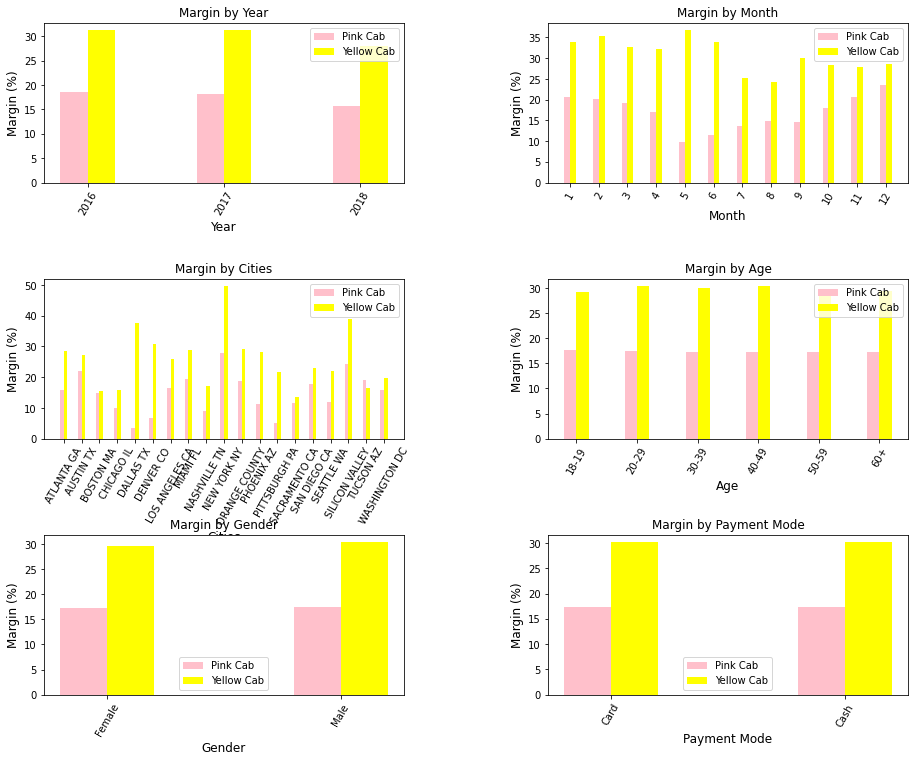

In [41]:
X=[Margin_Y_Pink.index, Margin_M_Pink.index, Margin_City_Pink.index, Margin_AgeRange_Pink.index, Margin_Gender_Pink.index, Margin_PaymentMode_Pink.index] 
Y1=[Margin_Y_Pink.values, Margin_M_Pink.values, Margin_City_Pink.values, Margin_AgeRange_Pink.values, Margin_Gender_Pink.values, Margin_PaymentMode_Pink.values] 
Y2=[Margin_Y_Yellow.values, Margin_M_Yellow.values, Margin_City_Yellow.values, Margin_AgeRange_Yellow.values, Margin_Gender_Yellow.values, Margin_PaymentMode_Yellow.values]
Xlab=["Year", "Month", "Cities","Age", "Gender", "Payment Mode"]                                                  
Ylab=['Margin (%)','Margin (%)','Margin (%)', 'Margin (%)','Margin (%)','Margin (%)']  
titles = ['Margin by Year', 'Margin by Month', 'Margin by Cities', 'Margin by Age', 'Margin by Gender', 'Margin by Payment Mode']            
fig = plt.figure(figsize=(15,25))
sub_axbarplot(X,Y1,Y2,Xlab,Ylab,titles,6,2,fig)

#### Analysis: it is observed that in 2016 and 2017 the porfit of the two companies kept constant, whereas a slight reduction is occured in 2018. The highest Margin of the Yellow cab companiy was in the fifth month whereas its lowest Margin was in the 8th month. Regarding the Pink Cab companiy it had a high Margin in the first and last months of the year whereas its lowest Margin was in the fifth month. The higest Margin for both companies was from NEW YORK although the Pink company had more customers from LOS ANGELES. It is also observed that the age, Gender and Payment mode looks like that they have no dependency on the Margin since they look constants. However, later, they will be studied in depth.  

## Margin Vs Number of Customers

To analyse the relationship between margin and nb of customers, we will plot the mean of margin per month vs nb of customers for each month during the 3 years. The analysis could be done for any city, however i will choose New York since it has the highest nb of customers.

In [42]:
df1 = Master_Data[(Master_Data.Company=='Pink Cab')&(Master_Data.City=='NEW YORK NY')].groupby(['Year','Month']).Margin.mean()
df2 = Master_Data[(Master_Data.Company=='Yellow Cab')&(Master_Data.City=='NEW YORK NY')].groupby(['Year','Month']).Margin.mean()
df3 = pd.DataFrame({'Company':'Pink Cab','Margin':df1.values,'Transactions':Master_Data[Master_Data.Company=='Pink Cab'].groupby(['Year','Month']).Transaction_ID.count().values})
df4 = pd.DataFrame({'Company':'Yellow Cab','Margin':df2.values,'Transactions':Master_Data[Master_Data.Company=='Yellow Cab'].groupby(['Year','Month']).Transaction_ID.count().values})
df=df3.append(df4)
df.sample(5)

,Company,Margin,Transactions
34,Pink Cab,123.915903,3897
3,Yellow Cab,338.014526,5360
33,Pink Cab,113.972785,3435
14,Pink Cab,65.847218,1503
33,Yellow Cab,251.091115,9727


<AxesSubplot:xlabel='Transactions', ylabel='Margin'>

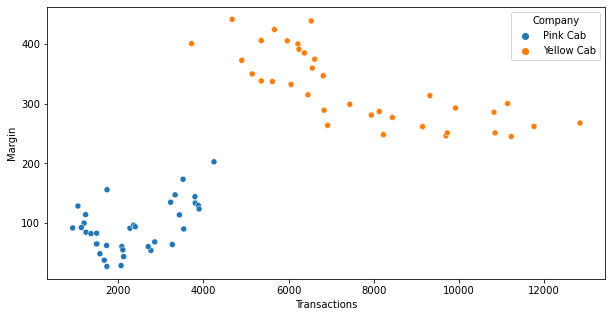

In [43]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x="Transactions",y="Margin",hue="Company")

#### Analysis: it is observed that Pink Cab increases its margins with increase in number of Transactions. However, the Yellow Cab decrease its Margin with the increase in Transactions.

## Correlation:
Before to get the correaltion between features, let's tranform the categorical data. 

In [44]:
df= Master_Data.copy()

categorical_columns =['Gender','Payment_Mode','Company','City']

for col_name in categorical_columns:
    df[col_name]= df[col_name].astype('category')
    print(dict(enumerate(df[col_name].cat.categories)))
    df[col_name] = df[col_name].cat.codes


df=df.drop(columns=['Customer_ID', 'Transaction_ID', 'Date_of_Travel', 'Age_Range','Margin_Percentage'])
df.corr()

{0: 'Female', 1: 'Male'}
{0: 'Card', 1: 'Cash'}
{0: 'Pink Cab', 1: 'Yellow Cab'}
{0: 'ATLANTA GA', 1: 'AUSTIN TX', 2: 'BOSTON MA', 3: 'CHICAGO IL', 4: 'DALLAS TX', 5: 'DENVER CO', 6: 'LOS ANGELES CA', 7: 'MIAMI FL', 8: 'NASHVILLE TN', 9: 'NEW YORK NY', 10: 'ORANGE COUNTY', 11: 'PHOENIX AZ', 12: 'PITTSBURGH PA', 13: 'SACRAMENTO CA', 14: 'SAN DIEGO CA', 15: 'SEATTLE WA', 16: 'SILICON VALLEY', 17: 'TUCSON AZ', 18: 'WASHINGTON DC'}


,Gender,Age,Income_USDMonth,Payment_Mode,Company,City,KM_Travelled,Price_Charged,Cost_of_Trip,Population,Users,Year,Month,Margin
Gender,1.000000,0.003366,-0.000991,-0.000080,0.017279,-0.011733,-0.001350,0.012661,0.000495,0.043593,0.060886,-0.012758,-0.014972,0.021182
Age,0.003366,1.000000,0.003907,-0.001118,0.000630,-0.008872,-0.000369,-0.003084,-0.000189,-0.009002,-0.005906,-0.000579,-0.002226,-0.005093
Income_USDMonth,-0.000991,0.003907,1.000000,-0.000866,-0.000712,-0.008725,-0.000544,0.003228,-0.000633,0.011868,0.010464,-0.001617,0.000322,0.006148
Payment_Mode,-0.000080,-0.001118,-0.000866,1.000000,-0.001026,-0.000885,-0.000766,0.000226,-0.000898,0.001544,0.001709,-0.000870,-0.001862,0.001273
Company,0.017279,0.000630,-0.000712,-0.001026,1.000000,0.002109,0.000333,0.227986,0.133713,0.130920,0.180476,-0.003287,-0.049657,0.258426
City,-0.011733,-0.008872,-0.008725,-0.000885,0.002109,1.000000,0.000471,0.037286,0.000776,0.000379,-0.005128,-0.000830,-0.005623,0.063052
KM_Travelled,-0.001350,-0.000369,-0.000544,-0.000766,0.000333,0.000471,1.000000,0.835753,0.981848,-0.002311,-0.000428,-0.001072,-0.001903,0.462768
Price_Charged,0.012661,-0.003084,0.003228,0.000226,0.227986,0.037286,0.835753,1.000000,0.859812,0.326589,0.281061,-0.036409,-0.061116,0.864154
Cost_of_Trip,0.000495,-0.000189,-0.000633,-0.000898,0.133713,0.000776,0.981848,0.859812,1.000000,0.015108,0.023628,-0.001773,-0.008370,0.486056
Population,0.043593,-0.009002,0.011868,0.001544,0.130920,0.000379,-0.002311,0.326589,0.015108,1.000000,0.915490,0.000003,0.064571,0.544079


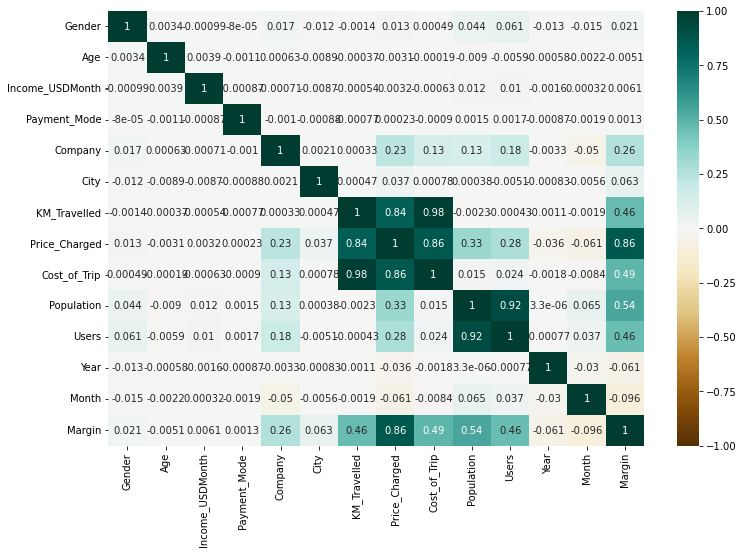

In [45]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1,cmap='BrBG')
plt.show()

#### Analysis: it is observed that there is a high correlation between Margin and Price_Charged

## Hypothesis Testing

#### Null Hypothesis:
    1. Margin remain the same regarding Gender for both Yellow Cab & Pink Cab
    2. Margin remain the same regarding Age for both Yellow Cab & Pink Cab
    3. Margin remain the same regarding mode of Payment for both Yellow Cab & Pink Cab

### Margin per Gender: 

In [46]:
#Margin per Gender - Pink Cab
data1 = Master_Data[(Master_Data.Gender=='Female')&(Master_Data.Company=='Pink Cab')].groupby('Transaction_ID').Margin.mean()
data2 = Master_Data[(Master_Data.Gender=='Male')&(Master_Data.Company=='Pink Cab')].groupby('Transaction_ID').Margin.mean()
print(data1.shape[0],data2.shape[0])

_, p_value = stats.ttest_ind(data1.values,data2.values,equal_var=True)
if(p_value<0.05):
    print('We reject the null hypothesis')
else:
    print('We accept the null hypothesis')
    
print('P value is ', p_value)

37480 47231
We accept the null hypothesis
P value is  0.11515305900425798


#### Conclusion: There is no difference in Margin between Male and Female customers for the Pink Cab: 

In [47]:
#Margin per Gender - Yellow Cab
data1 = Master_Data[(Master_Data.Gender=='Female')&(Master_Data.Company=='Yellow Cab')].groupby('Transaction_ID').Margin.mean()
data2 = Master_Data[(Master_Data.Gender=='Male')&(Master_Data.Company=='Yellow Cab')].groupby('Transaction_ID').Margin.mean()
print(data1.shape[0],data2.shape[0])

_, p_value = stats.ttest_ind(data1.values,data2.values,equal_var=True)
if(p_value<0.05):
    print('We reject the null hypothesis')
else:
    print('We accept the null hypothesis')
    
print('P value is ', p_value)

116000 158681
We reject the null hypothesis
P value is  6.060473042494144e-25


#### Conclusion: There is a difference in Margin between Male and Female customers for the Yellow Cab: 

### Margin per Age:

I will compare the Margin for ages less than 20, between 20 and 60, above 60.

In [48]:
#Margin per Age - Pink Cab 
data1 = Master_Data[(Master_Data.Age>=20)&(Master_Data.Age<60)&(Master_Data.Company=='Pink Cab')].groupby('Transaction_ID').Margin.mean()
data2 = Master_Data[(Master_Data.Age>=60)&(Master_Data.Company=='Pink Cab')].groupby('Transaction_ID').Margin.mean()
print(data1.shape[0],data2.shape[0])

_, p_value = stats.ttest_ind(data1.values,data2.values,equal_var=True)
if(p_value<0.05):
    print('We reject the null hypothesis')
else:
    print('We accept the null hypothesis')
    
print('P value is ', p_value)

73785 5429
We accept the null hypothesis
P value is  0.5367122200984391


#### Conclusion: Pink Cab does not give any discount to people older than 60

In [49]:
#Margin per Age - Pink Cab
data1 = Master_Data[(Master_Data.Age<20)&(Master_Data.Company=='Pink Cab')].groupby('Transaction_ID').Margin.mean()
data2 = Master_Data[(Master_Data.Age<60)&(Master_Data.Age>=20)&(Master_Data.Company=='Pink Cab')].groupby('Transaction_ID').Margin.mean()
print(data1.shape[0],data2.shape[0])

_, p_value = stats.ttest_ind(data1.values,data2.values,equal_var=True)
if(p_value<0.05):
    print('We reject the null hypothesis')
else:
    print('We accept the null hypothesis')
    
print('P value is ', p_value)

5497 73785
We accept the null hypothesis
P value is  0.47161921301987064


#### Conclusion: Pink Cab does not give any discount to young customers (<20)

In [50]:
#Margin per Age - Yellow Cab 
data1 = Master_Data[(Master_Data.Age>=20)&(Master_Data.Age<60)&(Master_Data.Company=='Yellow Cab')].groupby('Transaction_ID').Margin.mean()
data2 = Master_Data[(Master_Data.Age>=60)&(Master_Data.Company=='Yellow Cab')].groupby('Transaction_ID').Margin.mean()
print(data1.shape[0],data2.shape[0])

_, p_value = stats.ttest_ind(data1.values,data2.values,equal_var=True)
if(p_value<0.05):
    print('We reject the null hypothesis')
else:
    print('We accept the null hypothesis')
    
print('P value is ', p_value)

240484 17257
We reject the null hypothesis
P value is  2.4059987605935882e-05


#### Conclusion: Yellow Cab gives discount to people older than 60

In [51]:
#Margin per Age - Yellow Cab 
data1 = Master_Data[(Master_Data.Age>=20)&(Master_Data.Age<60)&(Master_Data.Company=='Yellow Cab')].groupby('Transaction_ID').Margin.mean()
data2 = Master_Data[(Master_Data.Age<20)&(Master_Data.Company=='Yellow Cab')].groupby('Transaction_ID').Margin.mean()
print(data1.shape[0],data2.shape[0])

_, p_value = stats.ttest_ind(data1.values,data2.values,equal_var=True)
if(p_value<0.05):
    print('We reject the null hypothesis')
else:
    print('We accept the null hypothesis')
    
print('P value is ', p_value)

240484 16940
We reject the null hypothesis
P value is  2.767424106241002e-05


#### Conclusion: Yellow Cab also gives discount to young customers (<20)

### Margin per Mode of Payment: 

In [52]:
#Margin per Mode of Payment - Pink Cab
data1 = Master_Data[(Master_Data.Payment_Mode=='Cash')&(Master_Data.Company=='Pink Cab')].groupby('Transaction_ID').Margin.mean()
data2 = Master_Data[(Master_Data.Payment_Mode=='Card')&(Master_Data.Company=='Pink Cab')].groupby('Transaction_ID').Margin.mean()
print(data1.shape[0],data2.shape[0])

_, p_value = stats.ttest_ind(data1.values,data2.values,equal_var=True)
if(p_value<0.05):
    print('We reject the null hypothesis')
else:
    print('We accept the null hypothesis')
    
print('P value is ', p_value)

33992 50719
We accept the null hypothesis
P value is  0.7900465828793288


#### Conclusion: There is no difference in Margin regarding mode of Payment for the Pink Cab 

In [53]:
#Margin per Mode of Payment - Yellow Cab 
data1 = Master_Data[(Master_Data.Payment_Mode=='Cash')&(Master_Data.Company=='Yellow Cab')].groupby('Transaction_ID').Margin.mean()
data2 = Master_Data[(Master_Data.Payment_Mode=='Card')&(Master_Data.Company=='Yellow Cab')].groupby('Transaction_ID').Margin.mean()
print(data1.shape[0],data2.shape[0])

_, p_value = stats.ttest_ind(data1.values,data2.values,equal_var=True)
if(p_value<0.05):
    print('We reject the null hypothesis')
else:
    print('We accept the null hypothesis')
    
print('P value is ', p_value)

109896 164785
We accept the null hypothesis
P value is  0.2933060638298729


#### Conclusion: There is no difference in Margin regarding mode of Payment for the Yellow Cab

# CONCLUSIONS
We have evaluated both cab companies on the following points and found Yellow cab better than Pink cab:

* Most Users prefer travelling with Yellow cab than Pink cab
* Users tarvelled mostly with Yellow cab on short and long distance trip
* Yellow cab company charged more in populated City which is a good strategy and increase its profit
* Yellow cab charged higher than Pink cab
* Yellow cab owns 71.9% of the total margin made by both companies

We will advise the XYZ company to invest in Yellow Cab company for its glorious benefit.

## Build the Model:
In this section I will build a model that predict the price charged for a certain trip based on several information. To do so, first i will remove the features that have no impact on the price in order to simplify the complixity of the model.

Based on the above anaylsis it was found that the Gender, Age, Company, City, KM Travelled, Month have considerable effect on the price. It shoud be noted that number of users (per city), population (per city), and cost of trip also have effect on the price but I will not use them since these information requires preior knowlage and I would like to generate a model that can be used by any any user or company. 

In [54]:
Final_df=df.drop(columns=['Income_USDMonth','Payment_Mode','Cost_of_Trip','Population','Users','Year','Margin'])
Features= Final_df.drop(columns=['Price_Charged'])
Target=Final_df.drop(columns=['Company', 'Age', 'Gender','KM_Travelled','City','Month'])

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(Features, Target, test_size=0.2, shuffle = True)

models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor()))
models.append(('RandomForestRegressor', RandomForestRegressor(n_estimators = 2, random_state = 0)))

train_accuracy=[]
test_accuracy=[]
predictions=[]
for name, model in models:
    model.fit(X_train,Y_train)
    prediction=model.predict(X_test)
    predictions.append(prediction)
    train_score = model.score(X_train,Y_train)
    test_score = model.score(X_test,Y_test)
    train_accuracy.append(round(train_score.mean(),2)*100)
    test_accuracy.append(round(test_score.mean(),2)*100)
#     or
#     train_model = cross_val_score(model, X_train, Y_train, cv=5, scoring='r2')
#     print('The accuracy of',name,'is',round(train_model.mean(),2)*100, '%')    
       
data = {'Train Accuracy (%)': train_accuracy, 'Test Accuracy (%)': test_accuracy}
df = pd.DataFrame(data,index=['Linear Regression','Decision Tree Regressor', 'Random Forest Regressor'])
df

/tmp/ipykernel_10196/2682203208.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)


,Train Accuracy (%),Test Accuracy (%)
Linear Regression,75.0,75.0
Decision Tree Regressor,100.0,86.0
Random Forest Regressor,97.0,89.0


In [81]:
model=RandomForestRegressor(n_estimators = 2, random_state = 0)
model.fit(X_train,Y_train)
prediction=model.predict(X_test)

/tmp/ipykernel_10196/3586983043.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)


### Visualize the predicted and actual Prices:

Text(0, 0.5, 'Price Charged')

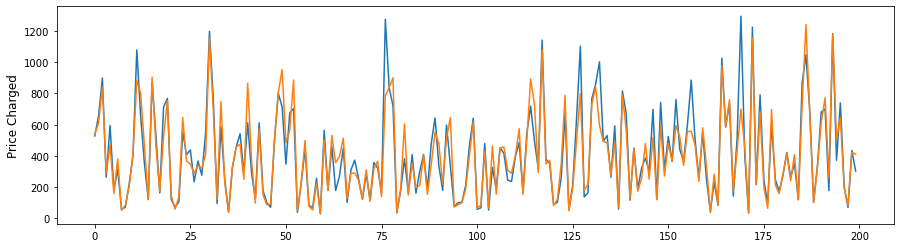

In [82]:
Y_test['Predictions']=prediction
Price_test=Y_test[:200]
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
plt.plot(Price_test[['Price_Charged','Predictions']].values)
plt.ylabel('Price Charged', fontsize = 12)

### Save model for later use

In [83]:
pickle.dump(model, open('RFRegressor.pkl','wb'))
model = pickle.load(open('RFRegressor.pkl','rb'))